In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
halos = {}
halos['lcdm'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_M13.npy')
halos['m26'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_26_10_M13.npy')
halos['m25'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_25_10_M13.npy')
halos['m24'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_24_10_M13.npy')
halos['m23'] = np.load('Trial_PP_halo_catalog_2048Mpc_n4096_1_23_10_M13.npy')

In [3]:
#plt.scatter(halos[][:,0][::100], halos[:,2][::100])

In [4]:
voids = {}
voids['lcdm'] = np.loadtxt('2048Mpc_n4096_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m26'] = np.loadtxt('2048Mpc_n4096_1_26_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m25'] = np.loadtxt('2048Mpc_n4096_1_25_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m24'] = np.loadtxt('2048Mpc_n4096_1_24_10_M13zobov-Voids_cat.txt', dtype=np.float32)
voids['m23'] = np.loadtxt('2048Mpc_n4096_1_23_10_M13zobov-Voids_cat.txt', dtype=np.float32)

In [5]:
hx = {}
hy = {}
hz = {}

vx = {}
vy = {}
vz = {}
vR = {}

for K in halos.keys():
    hx[K], hy[K], hz[K] = halos[K][:, :3].T + 1024 * .68
    vx[K] = (voids[K][:,1]-1024*.68)%(2048*.68)
    vy[K] = (voids[K][:,2]-1024*.68)%(2048*.68)
    vz[K] = (voids[K][:,3]-1024*.68)%(2048*.68)
    vR[K] = voids[K][:,4]

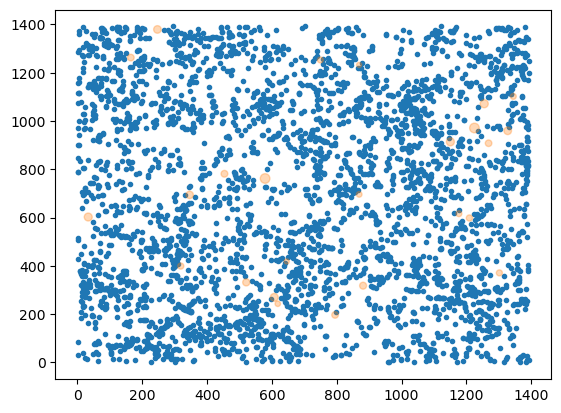

In [6]:
dzh = abs(hz['lcdm']) < 2.5
dzv = abs(vz['lcdm']) < 2.5
plt.scatter(hx['lcdm'][dzh], hy['lcdm'][dzh], marker='.')
plt.scatter(vx['lcdm'][dzv], vy['lcdm'][dzv], s=vR['lcdm'][dzv], alpha=0.3)

In [7]:
#plt.plot(np.diff([len(voids[:,4][voids[:,4]>rs[i]]) for i in range(len(rs))]))

In [8]:

#vx, vy, vz = np.array(voids[:, 1:4][voids[:,4]>5.].T, dtype=np.float32) 
#vx = (voids[:,1]-1024*.68)%(2048*.68)
#vy = (voids[:,2]-1024*.68)%(2048*.68)
#vz = (voids[:,3]-1024*.68)%(2048*.68)

In [9]:
#hz.min(), vz.min()

In [10]:
#    ND1,
#    ND2,
#    NR1,
#    NR2,
#    D1D2,
#    D1R2,
#    D2R1,
#    R1R2,

In [11]:
cf = {'gg':{}, 'gv':{}, 'vv':{}}

In [12]:
from Corrfunc.theory.DD import DD
from Corrfunc.io import read_catalog
from Corrfunc.utils import convert_3d_counts_to_cf



In [13]:
def compute_cfs(key, cf_dict):
    

    # Read the supplied galaxies on a periodic box
    X, Y, Z = hx[key], hy[key], hz[key]
    X2, Y2, Z2 = vx[key], vy[key], vz[key]
    ND1 = len(X)
    ND2 = len(X2)

    boxsize =  2048 * .68
    nthreads = 8

    # Generate randoms on the box
    rand_N1 = 3*ND1
    rand_X1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    rand_Y1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    rand_Z1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)


    #rand_X2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    #rand_Y2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
    #rand_Z2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)


    # Setup the bins
    nbins = 30
    bins = np.linspace(1, 150.0, nbins + 1) # note that +1 to nbins

    # Auto pair counts in DD
    autocorr=1
    D1D1_counts = DD(autocorr, nthreads, bins, X, Y, Z,
                  periodic=True, verbose=True, boxsize=boxsize)

    autocorr=1
    D2D2_counts = DD(autocorr, nthreads, bins, X2, Y2, Z2,
                  periodic=True, verbose=True, boxsize=boxsize)

    # Cross pair counts in DD
    autocorr=0
    D1D2_counts = DD(autocorr, nthreads, bins, X, Y, Z, X2=X2, Y2=Y2, Z2=Z2,
                  periodic=True, verbose=True, boxsize=boxsize)

    # Cross pair counts in DR
    autocorr=0
    D1R_counts = DD(autocorr, nthreads, bins, X, Y, Z,
                  X2=rand_X1, Y2=rand_Y1, Z2=rand_Z1,
                  periodic=True, verbose=True, boxsize=boxsize)

    # Cross pair counts in DR
    autocorr=0
    D2R_counts = DD(autocorr, nthreads, bins, X2, Y2, Z2,
                  X2=rand_X1, Y2=rand_Y1, Z2=rand_Z1,
                  periodic=True, verbose=True, boxsize=boxsize)

    # Auto pairs counts in RR
    autocorr=1
    RR_counts = DD(autocorr, nthreads, bins, rand_X1, rand_Y1, rand_Z1,
                   periodic=True, verbose=True, boxsize=boxsize)

    # All the pair counts are done, get the correlation function
    cf['gg'][key] = convert_3d_counts_to_cf(ND1, ND1, rand_N1, rand_N1,
                                D1D1_counts, D1R_counts,
                                D1R_counts, RR_counts)
    cf['vv'][key] = convert_3d_counts_to_cf(ND2, ND2, rand_N1, rand_N1,
                                D2D2_counts, D2R_counts,
                                D2R_counts, RR_counts)
    cf['gv'][key] = convert_3d_counts_to_cf(ND1, ND2, rand_N1, rand_N1,
                                D1D2_counts, D1R_counts,
                                D2R_counts, RR_counts)
    
    return

In [20]:
for key in ['m25']: #halos.keys():
    compute_cfs(key, cf)

Running with points in [xmin,xmax] = 0.000427,1392.639404 with periodic wrapping = 1392.640015
Running with points in [ymin,ymax] = 0.000671,1392.637451 with periodic wrapping = 1392.640015
Running with points in [zmin,zmax] = 0.000061,1392.639526 with periodic wrapping = 1392.640015
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 18,18,9.  Time taken =   0.102 sec
countpairs_float> gridlink seems inefficient. nmesh = (18, 18, 9); avg_np = 479. Boosting bin refine factor - should lead to better performance
xmin = 0.000427 xmax=1392.639404 rpmax = 150.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 27,27,9.  Time taken =   0.088 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 42.458 secs
Running with points in [xmin,xmax] = 0.105591,1392.156494 with periodic wrapping = 1392.640015
Running with points in [ymin,ymax] = 0.010132,1392.577148 with periodic w

In [15]:
'''# Read the supplied galaxies on a periodic box
X, Y, Z = hx['m26'][::5], hy['m26'][::5], hz['m26'][::5]
X2, Y2, Z2 = vx['m26'], vy['m26'], vz['m26']
ND1 = len(X)
ND2 = len(X2)

boxsize =  2048 * .68
nthreads = 8

# Generate randoms on the box
rand_N1 = 10*ND1
rand_X1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
rand_Y1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
rand_Z1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)


#rand_X2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
#rand_Y2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)
#rand_Z2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)


# Setup the bins
nbins = 30
bins = np.linspace(1, 100.0, nbins + 1) # note that +1 to nbins

# Auto pair counts in DD
autocorr=1
D1D1_counts = DD(autocorr, nthreads, bins, X, Y, Z,
              periodic=True, verbose=True, boxsize=boxsize)

autocorr=1
D2D2_counts = DD(autocorr, nthreads, bins, X2, Y2, Z2,
              periodic=True, verbose=True, boxsize=boxsize)

# Cross pair counts in DD
autocorr=0
D1D2_counts = DD(autocorr, nthreads, bins, X, Y, Z, X2=X2, Y2=Y2, Z2=Z2,
              periodic=True, verbose=True, boxsize=boxsize)

# Cross pair counts in DR
autocorr=0
D1R_counts = DD(autocorr, nthreads, bins, X, Y, Z,
              X2=rand_X1, Y2=rand_Y1, Z2=rand_Z1,
              periodic=True, verbose=True, boxsize=boxsize)

# Cross pair counts in DR
autocorr=0
D2R_counts = DD(autocorr, nthreads, bins, X2, Y2, Z2,
              X2=rand_X1, Y2=rand_Y1, Z2=rand_Z1,
              periodic=True, verbose=True, boxsize=boxsize)

# Auto pairs counts in RR
autocorr=1
RR_counts = DD(autocorr, nthreads, bins, rand_X1, rand_Y1, rand_Z1,
               periodic=True, verbose=True, boxsize=boxsize)

# All the pair counts are done, get the correlation function
cf['gg']['m26'] = convert_3d_counts_to_cf(ND1, ND1, rand_N1, rand_N1,
                            D1D1_counts, D1R_counts,
                            D1R_counts, RR_counts)
cf['vv']['m26'] = convert_3d_counts_to_cf(ND2, ND2, rand_N1, rand_N1,
                            D2D2_counts, D2R_counts,
                            D2R_counts, RR_counts)
cf['gv']['m26'] = convert_3d_counts_to_cf(ND1, ND2, rand_N1, rand_N1,
                            D1D2_counts, D1R_counts,
                            D2R_counts, RR_counts)'''

"# Read the supplied galaxies on a periodic box\nX, Y, Z = hx['m26'][::5], hy['m26'][::5], hz['m26'][::5]\nX2, Y2, Z2 = vx['m26'], vy['m26'], vz['m26']\nND1 = len(X)\nND2 = len(X2)\n\nboxsize =  2048 * .68\nnthreads = 8\n\n# Generate randoms on the box\nrand_N1 = 10*ND1\nrand_X1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)\nrand_Y1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)\nrand_Z1 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)\n\n\n#rand_X2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)\n#rand_Y2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)\n#rand_Z2 = np.array(np.random.uniform(0, boxsize, rand_N1), dtype=np.float32)\n\n\n# Setup the bins\nnbins = 30\nbins = np.linspace(1, 100.0, nbins + 1) # note that +1 to nbins\n\n# Auto pair counts in DD\nautocorr=1\nD1D1_counts = DD(autocorr, nthreads, bins, X, Y, Z,\n              periodic=True, verbose=True, boxsize=boxsize)\n

In [16]:
nbins = 30
bins = np.linspace(1, 150.0, nbins + 1) # note that +1 to nbins
rs = np.array([(bins[i+1]+bins[i])/2 for i in range(nbins)])

KeyError: 'm26'

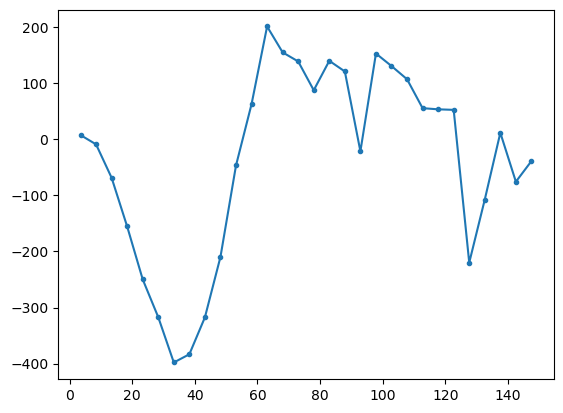

In [17]:
for key in halos.keys():
    plt.plot(rs, rs**2*cf['vv'][key], '.-', label=key)
plt.grid()
plt.xlabel('$r$', fontsize=16)
plt.ylabel('$r^2\\xi_{vv}(r)$', fontsize=16)
plt.legend()
#plt.savefig('vv_corr.png')

In [ ]:
from scipy.signal import savgol_filter

In [ ]:
plt.plot(rs, savgol_filter(rs**2*cf['vv']['m26'], 7, polyorder=1))

In [ ]:
plt.plot([-26, -25, -24, -23], [rs[np.argmin(savgol_filter(rs**2*cf['vv'][key], 5, polyorder=1))]
                                for key in ['m26', 'm25', 'm24', 'm23']])
plt.plot([-26, -25, -24, -23], [.8*rs[np.argmax(savgol_filter(rs**2*cf['gv'][key], 5, polyorder=1))]
                                for key in ['m26', 'm25', 'm24', 'm23']])
plt.plot([-26, -25, -24, -23], [1.1*np.mean(vR[key][vR[key]>=10])
                                for key in ['m26', 'm25', 'm24', 'm23']])

In [ ]:
from scipy.optimize import curve_fit, minimize

model = lambda x, a,b,c,d, a2, b2,c2,d2: (a*x**4+b*x**2 + c*x) / (a2*x**4+ b2*x**2 + c2*x +d2)

popt, _ = curve_fit(model, rs[(10<=rs)&(rs<=80)], (rs**2*cf['vv']['lcdm'])[(10<=rs)&(rs<=80)])

min_vv_corr = minimize(lambda x: model(x, *popt), x0=np.mean(vR['lcdm']), bounds=[(20,50)])['x']

rtest = np.linspace(0, 80, 200)
plt.plot(rtest, model(rtest, *popt))
plt.plot(rs, rs**2*cf['vv']['lcdm'], '.-')
plt.axvline(x=min_vv_corr)
print(min_vv_corr/np.mean(vR['lcdm'][vR['lcdm']>1]))

popt, _ = curve_fit(model, rs[(10<=rs)&(rs<=80)], (rs**2*cf['vv']['m26'])[(10<=rs)&(rs<=80)])

min_vv_corr = minimize(lambda x: model(x, *popt), x0=np.mean(vR['m26']), bounds=[(20,50)])['x']

rtest = np.linspace(0, 80, 200)
plt.plot(rtest, model(rtest, *popt))
plt.plot(rs, rs**2*cf['vv']['m26'], '.-')
plt.axvline(x=min_vv_corr)
print(min_vv_corr/np.mean(vR['m26'][vR['m26']>1]))

In [ ]:
for key in ['lcdm']: #halos.keys():
    plt.plot(rs, rs**2*cf['gg'][key], '.-', label=key)
plt.grid()
plt.xlabel('$r$', fontsize=16)
plt.ylabel('$r^2\\xi_{gg}(r)$', fontsize=16)
plt.legend()
#plt.savefig('gg_corr.png')

In [ ]:
#np.savetxt('gg_corr_lcdm.dat', np.array([rs, cf['gg']['lcdm']]))
#np.savetxt('gg_corr_m23.dat', np.array([rs, cf['gg']['m23']]))
#np.savetxt('gg_corr_m24.dat', np.array([rs, cf['gg']['m24']]))
np.savetxt('gg_corr_m25.dat', np.array([rs, cf['gg']['m25']]))
#np.savetxt('gg_corr_m26.dat', np.array([rs, cf['gg']['m26']]))

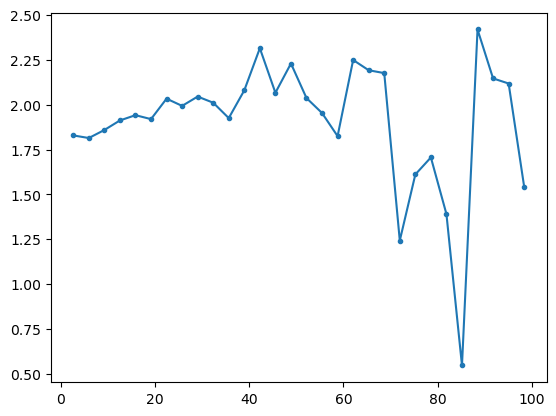

In [110]:
plt.plot(rs, cf['gg']['m26']/cf['gg']['lcdm'], '.-')

Text(0, 0.5, '$\\xi_{gv}(r)$')

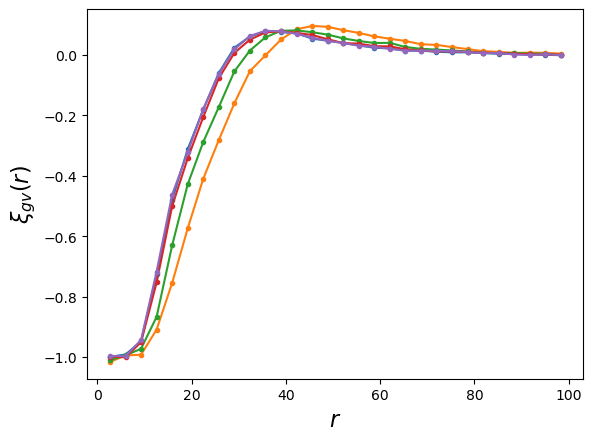

In [18]:
for key in halos.keys():
    plt.plot(rs, cf['gv'][key], '.-', label=key)
plt.xlabel('$r$', fontsize=16)
plt.ylabel('$\\xi_{gv}(r)$', fontsize=16)
#plt.savefig('gv_corr.png')

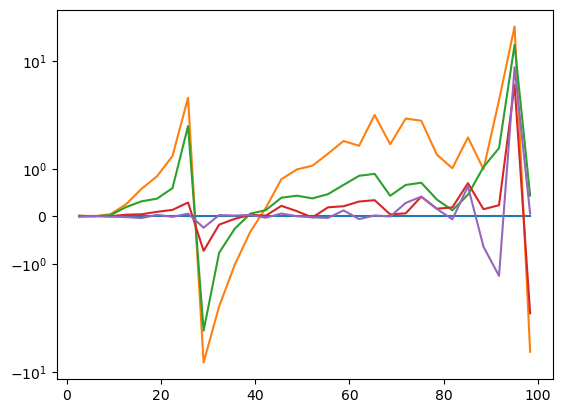

In [26]:
for key in halos.keys():    
    plt.plot(rs, cf['gv'][key]/cf['gv']['lcdm']-1)
#plt.ylim(-1.5, 1.5)
plt.yscale('symlog')

[1.16400259]
[1.23011338]


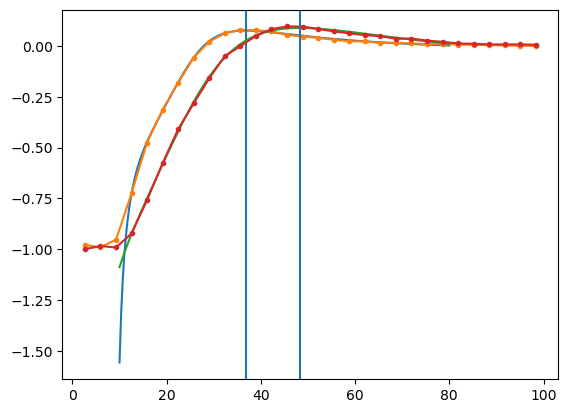

In [117]:
model = lambda x, a,b,c,d, a2, b2,c2,d2: (a*x**4+b*x**2 + c*x) / (a2*x**4+ b2*x**2 + c2*x +d2)

popt, _ = curve_fit(model, rs[(10<=rs)&(rs<=80)], (cf['gv']['lcdm'])[(10<=rs)&(rs<=80)])

min_vv_corr = minimize(lambda x: -model(x, *popt), x0=np.mean(vR['lcdm']), bounds=[(10,70)])['x']

rtest = np.linspace(10, 80, 200)
plt.plot(rtest, model(rtest, *popt))
plt.plot(rs, cf['gv']['lcdm'], '.-')
plt.axvline(x=min_vv_corr)
print(min_vv_corr/np.mean(vR['lcdm'][vR['lcdm']>1]))

popt, _ = curve_fit(model, rs[(10<=rs)&(rs<=80)], (cf['gv']['m26'])[(10<=rs)&(rs<=80)])

min_vv_corr = minimize(lambda x: -model(x, *popt), x0=np.mean(vR['m26']), bounds=[(10,70)])['x']

rtest = np.linspace(10, 80, 200)
plt.plot(rtest, model(rtest, *popt))
plt.plot(rs, cf['gv']['m26'], '.-')
plt.axvline(x=min_vv_corr)
print(min_vv_corr/np.mean(vR['m26'][vR['m26']>1]))

In [1]:
'''hist, bin_edges = np.histogram(vR['lcdm'], bins=np.geomspace(20, 75, 25), )
plt.semilogy(np.geomspace(20, 75, 24), np.gradient(np.cumsum(hist), np.geomspace(20, 75, 24)))

hist, bin_edges = np.histogram(vR['m26'], bins=np.geomspace(20, 75, 25), )
plt.semilogy(np.geomspace(20, 75, 24), np.gradient(np.cumsum(hist), np.geomspace(20, 75, 24)))'''

"hist, bin_edges = np.histogram(vR['lcdm'], bins=np.geomspace(20, 75, 25), )\nplt.semilogy(np.geomspace(20, 75, 24), np.gradient(np.cumsum(hist), np.geomspace(20, 75, 24)))\n\nhist, bin_edges = np.histogram(vR['m26'], bins=np.geomspace(20, 75, 25), )\nplt.semilogy(np.geomspace(20, 75, 24), np.gradient(np.cumsum(hist), np.geomspace(20, 75, 24)))"

In [2]:
#print(np.mean(vR['lcdm'][vR['lcdm']>15]))
#print(np.mean(vR['m26'][vR['m26']>15]))